# Importing Dependencies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

To ensure we get reproducible results we set the random seed for Python, Numpy and PyTorch.

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

The first thing we'll do is load our dataset.

In [3]:
ROOT = '.data'

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)

## Calculating mean and standard deviation of training dataset.

In [4]:
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

In [5]:
print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

Calculated mean: 0.13066047430038452
Calculated std: 0.30810779333114624


## Creating transforms for training and testing datasets.

In [6]:
T = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((mean, ), (std, ))
])

Now we have defined our transforms we can then load the train and test data.

In [7]:
train_data = datasets.MNIST(
  ROOT,
  train=True,
  download=True,
  transform=T
)

test_data = datasets.MNIST(
  ROOT,
  train=False,
  download=True,
  transform=T
)

We can simply check the `len` of the datasets to see how many examples are within each.

In [8]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 60000
Number of testing examples: 10000


## Visualising data.

In [9]:
def plot_images(images):
    n_images = len(images)

    rows = cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows * cols):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

Visualising training images.

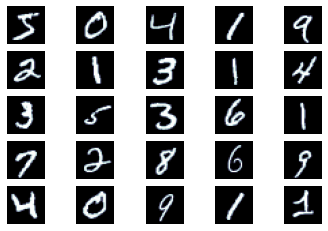

In [10]:
NUM_IMAGES = 25
images = [image for image, label in [train_data[i] for i in range(NUM_IMAGES)]]
plot_images(images)

Splitting training dataset into training and validation.

In [11]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

Then, we use the `random_split` function to take a random 10% of the training set to use as a validation set. The remaining 90% will stay as the training set.

In [12]:
train_data, valid_data = data.random_split(
  train_data,
  [n_train_examples, n_valid_examples]
)

We can print out the number of examples again to check our splits are correct.

In [13]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


## Visualising datasets

Visualizing train images

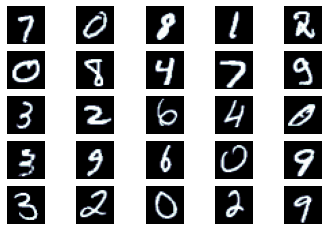

In [14]:
NUM_IMAGES = 25
images = [image for image, label in [train_data[i] for i in range(NUM_IMAGES)]]
plot_images(images)

Visualizing validation images

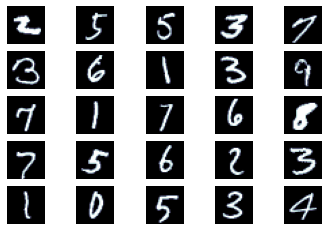

In [15]:
NUM_IMAGES = 25
images = [image for image, label in [valid_data[i] for i in range(NUM_IMAGES)]]
plot_images(images)

Visualising validation dataset after changes.

In [16]:
BATCH_SIZE = 64

train_dataloader = data.DataLoader(
  train_data,
  shuffle=True,
  batch_size=BATCH_SIZE
)

valid_dataloader = data.DataLoader(
  valid_data,
  batch_size=BATCH_SIZE
)

test_dataloader = data.DataLoader(
  test_data,
  batch_size=BATCH_SIZE
)

# Defining Model

In [26]:
class MLP(nn.Module):
  def __init__(self, n_features, num_classes):
    super().__init__()

    self.fc1 = nn.Linear(n_features, 250)
    self.fc2 = nn.Linear(250, 100)
    self.fc3 = nn.Linear(100, num_classes)

    self.relu = nn.ReLU()

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.fc3(x)
    return x

We'll define our model by creating an instance of it and setting the correct input and output dimensions.

In [27]:
N_FEATURES = 1 * 28 * 28
NUM_CLASSES = 10

model = MLP(N_FEATURES, NUM_CLASSES)

### Training the Model

Defining optimizer

In [28]:
optimizer = optim.Adam(model.parameters())

Defining loss function

In [29]:
criterion = nn.CrossEntropyLoss()

We then define `device`. This is used to place your model and data on to a GPU, if you have one.

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

We place our model and criterion on to the device by using the `.to` method.

In [31]:
model = model.to(device)
criterion = criterion.to(device)

Defining training loop

In [32]:
def train(model, dataloader, optimizer, criterion, device):
  model.train()
    
  losses, corrects = [], 0
  for images, labels in tqdm(dataloader, desc="Training"):
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    predictions = model(images)
    loss = criterion(predictions, labels)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    corrects += (torch.argmax(predictions, dim=1) == labels).sum()

  train_loss = sum(losses) / len(dataloader)
  train_accuracy = 100.0 * corrects / len(dataloader.dataset)
  return train_loss, train_accuracy

Defining evaluation loop

In [33]:
def evaluate(model, dataloader, criterion, device):
  model.eval()

  losses, corrects = [], 0
  with torch.no_grad():
    for images, labels in tqdm(dataloader, desc="Evaluating"):
      images, labels = images.to(device), labels.to(device)
      
      predictions = model(images)
      loss = criterion(predictions, labels)

      losses.append(loss.item())
      corrects += (torch.argmax(predictions, dim=1) == labels).sum()

  valid_loss = sum(losses) / len(dataloader)
  valid_accuracy = 100.0 * corrects / len(dataloader.dataset)
  return valid_loss, valid_accuracy

We're finally ready to train!

During each epoch we calculate the training loss and accuracy, followed by the validation loss and accuracy. We then check if the validation loss achieved is the best validation loss we have seen. If so, we save our model's parameters (called a `state_dict`).

In [34]:
N_EPOCHS = 10
best_valid_accuracy = 0.0

for epoch in trange(N_EPOCHS):
  train_loss, train_accuracy = train(model, train_dataloader, optimizer, criterion, device)
  valid_loss, valid_accuracy = evaluate(model, valid_dataloader, criterion, device)

  print(f'After Epoch {epoch}')
  print(f'Train Loss: {train_loss:.6f}, Train Accuracy: {train_accuracy:.2f}%')
  print(f'Validation Loss: {valid_loss:.6f}, Validation Accuracy: {valid_accuracy:.2f}%')
  print('\n' + ('=' * 100) + '\n')

  if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    torch.save(model.state_dict(), 'best_model.pt')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

After Epoch 0
Train Loss: 0.245312, Train Accuracy: 92.67%
Validation Loss: 0.133649, Validation Accuracy: 95.95%




Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

After Epoch 1
Train Loss: 0.097278, Train Accuracy: 96.95%
Validation Loss: 0.099982, Validation Accuracy: 96.93%




Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

After Epoch 2
Train Loss: 0.066481, Train Accuracy: 97.91%
Validation Loss: 0.090073, Validation Accuracy: 97.28%




Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

After Epoch 3
Train Loss: 0.051768, Train Accuracy: 98.31%
Validation Loss: 0.090712, Validation Accuracy: 97.43%




Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

After Epoch 4
Train Loss: 0.040004, Train Accuracy: 98.69%
Validation Loss: 0.101170, Validation Accuracy: 97.12%




Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

After Epoch 5
Train Loss: 0.033303, Train Accuracy: 98.86%
Validation Loss: 0.104746, Validation Accuracy: 97.17%




Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

After Epoch 6
Train Loss: 0.029263, Train Accuracy: 99.06%
Validation Loss: 0.097314, Validation Accuracy: 97.38%




Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

After Epoch 7
Train Loss: 0.023621, Train Accuracy: 99.18%
Validation Loss: 0.102939, Validation Accuracy: 97.42%




Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

After Epoch 8
Train Loss: 0.021123, Train Accuracy: 99.29%
Validation Loss: 0.106190, Validation Accuracy: 97.52%




Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

After Epoch 9
Train Loss: 0.020842, Train Accuracy: 99.28%
Validation Loss: 0.116897, Validation Accuracy: 97.58%




Afterwards, we load our the parameters of the model that achieved the best validation loss and then use this to evaluate our model on the test set.

In [35]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_dataloader, criterion, device)
print(f'Test Loss: {test_loss:.6f}, Test Acc: {test_acc:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.083105, Test Acc: 97.96%


Our model achieves 98% accuracy on the test set.

This can be improved by tweaking hyperparameters, e.g. number of layers, number of neurons per layer, optimization algorithm used, learning rate, etc. 

### Examining the Model

Now we've trained our model, there are a few things we can look at. Most of these are simple exploratory analysis, but they can offer some insights into your model.

An important thing to do is check what examples your model gets wrong and ensure that they're reasonable mistakes.

The function below will return the model's predictions over a given dataset. It will return the inputs (image) the outputs (model predictions) and the ground truth labels.

In [66]:
def get_predictions(model, dataloader, device):
  model.eval()

  true_labels = []
  predicted_labels = []

  with torch.no_grad():
    for images, labels in dataloader:
      images, labels = images.to(device), labels.to(device)

      predictions = model(images)
      predictions = F.softmax(predictions, dim=-1)

      true_labels.append(labels.cpu())
      predicted_labels.append(torch.argmax(predictions, dim=1).cpu())

  true_labels = torch.cat(true_labels, dim=0)
  predicted_labels = torch.cat(predicted_labels, dim=0)

  return true_labels, predicted_labels

We can then get these predictions and, by taking the index of the highest predicted probability, get the predicted labels.

In [67]:
true_labels, predicted_labels = get_predictions(model, test_dataloader, device)

Then, we can make a confusion matrix from our actual labels and our predicted labels.

In [68]:
def plot_confusion_matrix(true_labels, predicted_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(true_labels, predicted_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

The results seem reasonable enough, the most confused predictions-actuals are: 3-5 and 2-7.

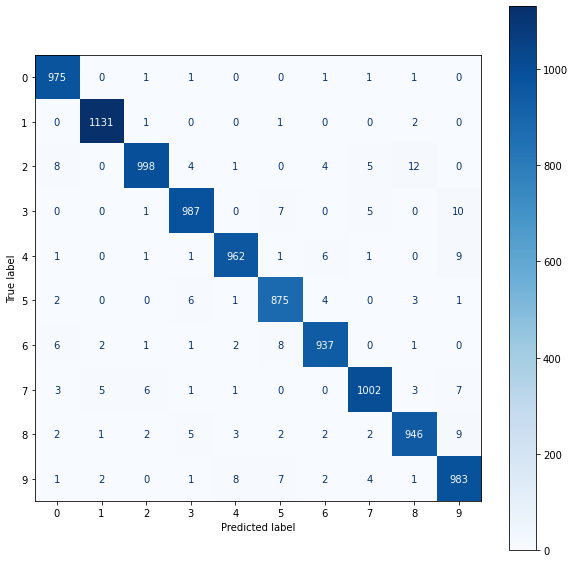

In [69]:
plot_confusion_matrix(true_labels, predicted_labels)